# Axial Braiding

In [165]:
import numpy as np
from matplotlib import pyplot as  plt
import scipy as sc
from scipy import special as sp
import cmath as cm

#define global parameters for Airy function
C = 1
r_0 = 5*10**-4 #0.5 mm
a = 0.2
s = 1.2*10**-4 #0.12 mm
#other parameters
wavelength = 1.064*10**-6 #1064 nm
k_0 = 2*np.pi/wavelength

def airy(x,y,z):
    #obtain field of Airy field at any position
    r = np.sqrt(x**2 + y**2)
    x0 = (r_0 - r)/s
    xi = z/(k_0 * s**2)
    g = sp.airy(x0 - (xi**2)/4 + 1j*a*xi)[0] * np.exp(a*x0 - a*(xi**2)/2) * np.exp(1j*(x0*xi/2 + a**2*xi/2 - xi**3/12))
    #print focusing length found:
    z_f = 2*k_0*(s**2)*np.sqrt(r_0/s + 1.018 - (a**2)) #0.385m
    u_CAB = C * g * np.exp(1j*k_0*z)
    return u_CAB
    
def Airy_transverse_map(z):
    #plot landscape of Airy intensity at any z
    xmax = 1*10**-3
    dx = 1*10**-5
    xlist, ylist = np.arange(-xmax, xmax, dx), np.arange(-xmax, xmax, dx)
    size = int(2*xmax/dx)
    I_CAB_z_array = np.zeros((size, size))
    z_f = 2*k_0*(s**2)*np.sqrt(r_0/s + 1.018 - (a**2))
    for row in range(len(I_CAB_z_array)):
        for col in range(len(I_CAB_z_array)):
            x, y = xlist[row], ylist[col]
            intensity = np.real(airy(x,y,z))**2 + np.imag(airy(x,y,z))**2
            I_CAB_z_array[row][col] = intensity
    plt.figure()
    plt.xlabel('x (10 microns)') #1 px = 10 microns
    plt.ylabel('y (10 microns)')
    plt.imshow(I_CAB_z_array, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    return

def bessel(x,y,z):
    #obtain bessel field at any location
    #the parameters A, theta, l are set by the experimenters:
    A, theta, l = 1, 0.005, 2 #5, 8 mrad were used for theta
    #obtain intensity of bessel field at any point
    r = np.sqrt(x**2 + y**2)
    if x == 0:
        phi = (np.pi)/2
    else:
        phi = np.arctan(y/x)
    u_B = A * sp.jv(l,k_0*np.sin(theta)*r) * np.exp(1j*(l*phi + k_0*np.cos(theta)*z)) #Bessel function always goes to 0 as arg goes to 0, unless l=0
    return u_B

def Bessel_transverse_map(z):
    #plot landscape of Bessel intensity at any z
    xmax = 1*10**-3
    dx = 1*10**-5
    xlist, ylist = np.arange(-xmax, xmax, dx), np.arange(-xmax, xmax, dx)
    size = int(2*xmax/dx)
    I_Bessel_z_array = np.zeros((size, size))
    z_f = 2*k_0*(s**2)*np.sqrt(r_0/s + 1.018 - (a**2))
    for row in range(len(I_Bessel_z_array)):
        for col in range(len(I_Bessel_z_array)):
            x, y = xlist[row], ylist[col]
            intensity = np.real(bessel(x,y,z))**2 + np.imag(bessel(x,y,z))**2  
            I_Bessel_z_array[row][col] = intensity
    plt.figure()
    plt.xlabel('x (10 microns)') #1 px = 10 microns
    plt.ylabel('y (10 microns)')
    plt.imshow(I_Bessel_z_array, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    return

def x_z_braiding(y, A, theta, l):
    #plot an x-z cut of the superposed fields
    xmax, zmax = 1*10**-3, 1.0
    dx, dz = 1*10**-5, 1*10**-3
    xlist = np.arange(-xmax, xmax, dx)
    zlist = np.arange(0, zmax, dz)
    intensity_array = np.zeros((len(zlist), len(xlist)))
    for zindex in range(len(zlist)): #rows are y-axis -> z
        for xindex in range(len(xlist)): #cols are x-axis
            x = xlist[xindex]
            z = zlist[zindex]
            r = np.sqrt(x**2 + y**2)
            if x == 0:
                phi = (np.pi)/2
            else:
                phi = np.arctan(y/x)
            u_B = A * sp.jv(l,k_0*np.sin(theta)*r) * np.exp(1j*(l*phi + k_0*np.cos(theta)*z))
            field = u_B + airy(x,y,z) #superposed
            I = np.imag(field)**2 + np.real(field)**2
            intensity_array[zindex][xindex] = I
    plt.figure(figsize=(12,6))
    plt.xlabel('x')
    plt.ylabel('z')
    plt.imshow(intensity_array, cmap = 'rainbow', interpolation = 'nearest')
    plt.colorbar()
    return

def x_y_map(z, A, theta, l):
    #intensity profiles of superposed beams in x-y
    xmax = 0.5*10**-3
    dx = 1*10**-5
    xlist, ylist = np.arange(-xmax, xmax, dx), np.arange(-xmax, xmax, dx)
    size = int(2*xmax/dx)
    int_array = np.zeros((size, size))
    for row in range(len(int_array)):
        for col in range(len(int_array)):
            x, y = xlist[row], ylist[col]
            r = np.sqrt(x**2 + y**2)
            if x == 0:
                phi = (np.pi)/2
            else:
                phi = np.arctan(y/x)
            u_B = A * sp.jv(l,k_0*np.sin(theta)*r) * np.exp(1j*(l*phi + k_0*np.cos(theta)*z)) 
            field = u_B + airy(x,y,z)
            intensity = np.imag(field)**2 + np.real(field)**2
            int_array[row][col] = intensity
    plt.figure()
    plt.xlabel('x') #1 px = 10 microns
    plt.ylabel('y')
    plt.imshow(int_array, cmap = 'rainbow', interpolation = 'nearest')
    plt.colorbar()
    return

def bessel_airy(x,y,z):
    #an airy function is just a superposition of two modified bessel beams, and we should be able to recreate results
    r = np.sqrt(x**2 + y**2)
    x0 = (r_0 - r)/s
    xi = z/(k_0 * s**2)
    arg = x0 - (xi**2)/4 + 1j*a*xi
    zeta = 2/3 * abs(arg)**(3/2)
    ai =  cm.sqrt(arg)/3 * (sp.iv(-1/3,zeta) - sp.iv(1/3,zeta)) #airy function made from modified bessel functions
    g =  ai * np.exp(a*x0 - a*(xi**2)/2) * np.exp(1j*(x0*xi/2 + a**2*xi/2 - (xi**3)/12))
    u_bessel_sup = C * g * np.exp(1j*k_0*z)
    return u_bessel_sup

# Notes:
#### Airy beam propagates as expected. Bessel beam has zero at center for higher order, maximum at center for l=0. 
#### Still curious about Bessel intensity not depending on z (non-diffracting?). No wonder braid starting position does not depend on Bessel parameters
#### x-y plots look similar to what was reported qualitatively (some differences quantitatively). Play around with parameters?

# Airy and Bessel maps at $z_{f}$

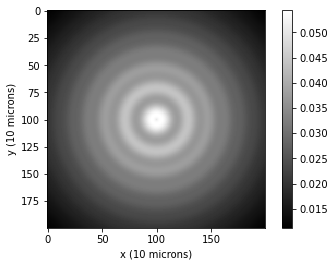

In [111]:
Airy_transverse_map(0.38)

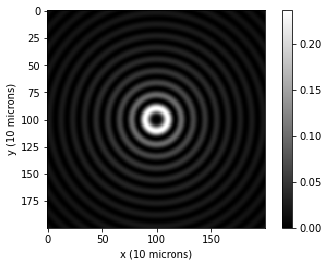

In [18]:
Bessel_transverse_map(0.38)

In [ ]:
airy(10**-3, 10**-3, 0.38)

# x-z braiding:

#### Arguments are: y, A (bessel beam power, typically 1), theta (5$\times$10$^{-3}$) used by experimenters), TC (typically 2)

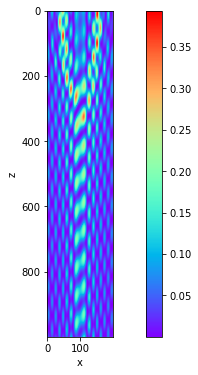

In [164]:
x_z_braiding(0.2*10**-3, 1, 0.005, 2)

# x-y plots, with l=2 (before and after braiding)

#### Arguments are: z, A (bessel beam power, typically 1), theta (5$\times$10$^{-3}$) used by experimenters), TC (typically 2)

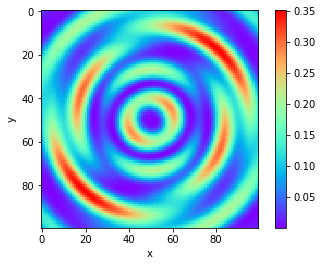

In [144]:
x_y_map(0.2, 1, 5*10**-3, 2)

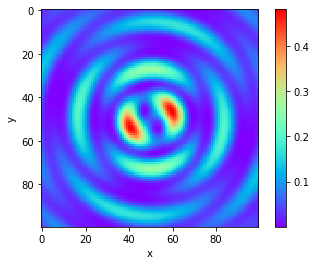

In [146]:
x_y_map(0.386, 1, 5*10**-3, 2)

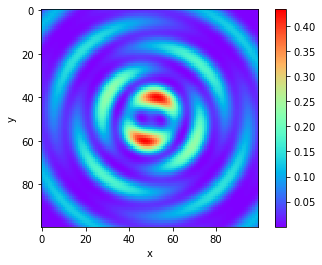

In [148]:
x_y_map(0.5, 1, 5*10**-3, 2)